# Setup Notebook

Install fast.ai packages for Colab

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Allow Colab to read/write to/from Drive.

***Always append base_dir to beginning of root paths*** - (maybe)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Install packages

In [0]:
from fastai.tabular import *
from fastai.vision import *
from fastai.widgets import *

# Create Dataset

Create the classes(labels) and their associated url files

In [0]:
classes = ['chicken', 'duck', 'goose', 'swan']

Import folders with images from drive

In [5]:
dataFolder = Path('/content/data/')

shutil.copyfile(Path('/content/gdrive/My Drive/birds.zip'), dataFolder/'birds.zip')

!unzip '/content/data/birds.zip'

birdFolder = Path('/content/birds/')
birdFolder.ls()
  
  

Archive:  /content/data/birds.zip
   creating: birds/
  inflating: birds/.DS_Store         
   creating: __MACOSX/
   creating: __MACOSX/birds/
  inflating: __MACOSX/birds/._.DS_Store  
   creating: birds/duck/
  inflating: birds/duck/00000170.jpg  
   creating: __MACOSX/birds/duck/
  inflating: __MACOSX/birds/duck/._00000170.jpg  
  inflating: birds/duck/00000038.jpg  
  inflating: __MACOSX/birds/duck/._00000038.jpg  
  inflating: birds/duck/00000010.jpg  
  inflating: __MACOSX/birds/duck/._00000010.jpg  
  inflating: birds/duck/00000004.jpg  
  inflating: __MACOSX/birds/duck/._00000004.jpg  
  inflating: birds/duck/00000005.jpg  
  inflating: __MACOSX/birds/duck/._00000005.jpg  
  inflating: birds/duck/00000011.jpg  
  inflating: __MACOSX/birds/duck/._00000011.jpg  
  inflating: birds/duck/00000039.jpg  
  inflating: __MACOSX/birds/duck/._00000039.jpg  
  inflating: birds/duck/00000171.jpg  
  inflating: __MACOSX/birds/duck/._00000171.jpg  
  inflating: birds/duck/00000159.jpg  
  in

[PosixPath('/content/birds/duck'),
 PosixPath('/content/birds/swan'),
 PosixPath('/content/birds/chicken'),
 PosixPath('/content/birds/goose'),
 PosixPath('/content/birds/.DS_Store')]

Verify images and delete any non-image files

In [0]:
for c in classes:
  print(c)
  path = Path('/content/birds')
  verify_images(path/c, delete=True, max_size=500)

Create a copy of the data folder in drive

In [7]:
!zip -r /content/data/birds.zip /content/birds
from google.colab import files
files.download("/content/data/birds.zip")

  adding: content/birds/ (stored 0%)
  adding: content/birds/duck/ (stored 0%)
  adding: content/birds/duck/00000176.jpg (deflated 0%)
  adding: content/birds/duck/00000021.jpg (deflated 1%)
  adding: content/birds/duck/00000105.jpg (deflated 1%)
  adding: content/birds/duck/00000112.jpg (deflated 1%)
  adding: content/birds/duck/00000196.jpg (deflated 2%)
  adding: content/birds/duck/00000057.jpg (deflated 0%)
  adding: content/birds/duck/00000043.jpg (deflated 0%)
  adding: content/birds/duck/00000096.jpg (deflated 2%)
  adding: content/birds/duck/00000051.jpg (deflated 1%)
  adding: content/birds/duck/00000068.jpg (deflated 1%)
  adding: content/birds/duck/00000142.jpg (deflated 1%)
  adding: content/birds/duck/00000116.jpg (deflated 1%)
  adding: content/birds/duck/00000088.jpg (deflated 0%)
  adding: content/birds/duck/00000064.jpg (deflated 1%)
  adding: content/birds/duck/00000040.jpg (deflated 0%)
  adding: content/birds/duck/00000009.jpg (deflated 1%)
  adding: content/birds/d

KeyboardInterrupt: ignored

In [0]:
shutil.move('/content/data/birds', '/content/gdrive/My Drive/ml-data/birds' )

'/content/gdrive/My Drive/ml-data/birds'

set seed for validation set,, create dataset

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [9]:
data.classes

['chicken', 'duck', 'goose', 'swan']

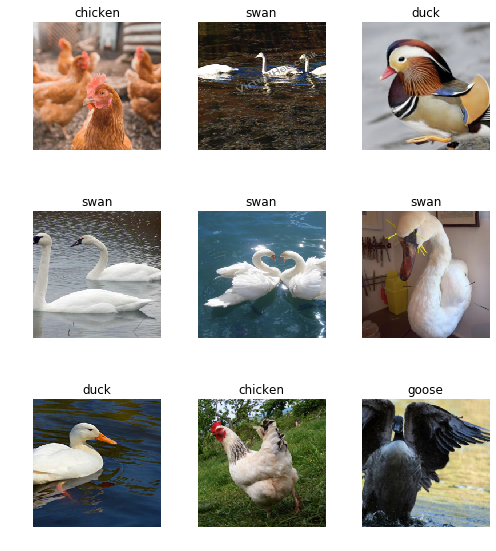

In [10]:
data.show_batch(rows=3, figsize=(7,8))

# Train the Model

Create neural net, train for 4 epochs, save the results as stage 1

In [11]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)
learn.fit_one_cycle(5)
learn.save('stage-1')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 41914388.55it/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.380657,0.524527,0.108527,00:11
1,0.843790,0.269169,0.069767,00:10
2,0.599550,0.231360,0.077519,00:10
3,0.455809,0.230610,0.085271,00:11
4,0.373346,0.226308,0.069767,00:10


Unfreeze, create learning rate graph

In [0]:
learn.unfreeze()

In [13]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


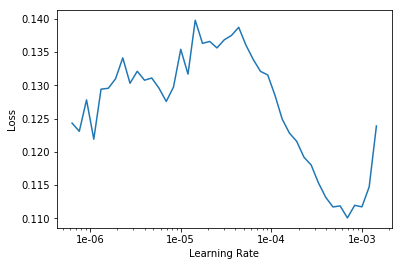

In [14]:
learn.recorder.plot()

Train for 2 more epochs, save the results

In [21]:
learn.load('stage-1')
learn.fit_one_cycle(4, max_lr=slice(1.5e-4,2.5e-4))
learn.save('stage-2')

epoch,train_loss,valid_loss,error_rate,time
0,0.117989,0.220109,0.062016,00:11
1,0.102642,0.227333,0.069767,00:11
2,0.084302,0.285138,0.077519,00:11
3,0.069204,0.261299,0.054264,00:11


# Interpret Results

Load trained net, create confusion matrix to evaluate performance

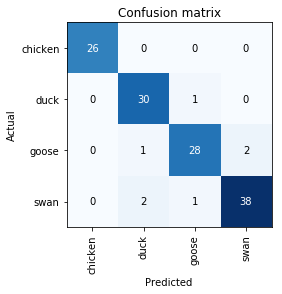

In [23]:
learn.load('stage-2')

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

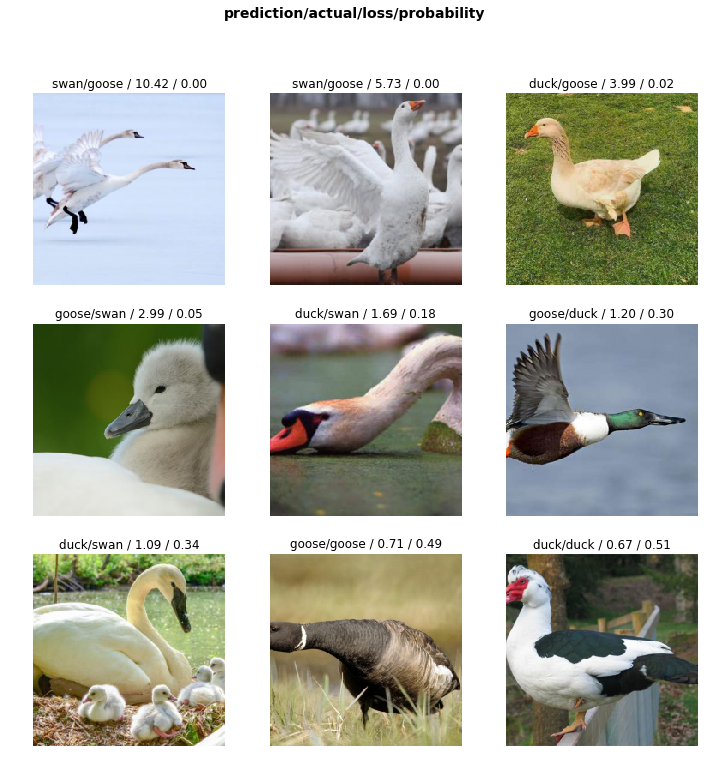

In [24]:
interp.plot_top_losses(9)

# Putting Model in Production

Export Model

In [0]:
learn.export()

Set to run on CPU

In [0]:
defaults.device = torch.device('cpu')

Create production learner, then start predicting

In [0]:
learn = load_learner(path)

In [0]:
img = open_image(path/'goose/00000002.jpg')

In [33]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category goose